In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Subset
import cv2
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_loc = "drive/MyDrive/Columbia Research/Bose Einstein Condensation ML/data/rotating_gs"
model_loc = "drive/MyDrive/Columbia Research/Bose Einstein Condensation ML/models"

#Wandb constants
entity="HPML-final-team"
project="HPML Final Project"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data


## GS Data Setup

In [ ]:
data = np.load(f"{data_loc}/density_scaled_phase_gradients.npz")
densities = data["probability_densities"]
phase_gradients = data["phase_gradients"]
params = data["g_omega_it_arr"]
masks = data["masks"].astype(float)

# Predefined training, valildation, testing groups
train_groups = torch.load(f"{data_loc}/train_groups.pth")
val_groups = torch.load(f"{data_loc}/val_groups.pth")
test_groups = torch.load(f"{data_loc}/test_groups.pth")
group_size = 4

In [ ]:
#To torch
densities = torch.from_numpy(densities).float().unsqueeze(1)
phase_gradients = torch.from_numpy(phase_gradients).float()
masks = torch.from_numpy(masks).float()

print(densities.shape)
print(phase_gradients.shape)
print(masks.shape)

torch.Size([1680, 1, 200, 200])
torch.Size([1680, 2, 200, 200])
torch.Size([1680, 2, 200, 200])


In [ ]:
# Data transformation
densities = torch.log(densities)

In [ ]:
#train/val/test split, but keep each group of g and omega parameters together to avoid data leakage

def extract_groups(stack, groups):
    indices = torch.cat([torch.arange(i * group_size, (i + 1) * group_size) for i in groups])
    return stack[indices]

# Apply to all stacks
train_densities = extract_groups(densities, train_groups)
train_phases = extract_groups(phase_gradients, train_groups)
train_masks = extract_groups(masks, train_groups)
train_params = extract_groups(params, train_groups)


val_densities = extract_groups(densities, val_groups)
val_phases = extract_groups(phase_gradients, val_groups)
val_masks = extract_groups(masks, val_groups)

test_densities = extract_groups(densities, test_groups)
test_phases = extract_groups(phase_gradients, test_groups)
test_masks = extract_groups(masks, test_groups)
test_params = extract_groups(params, test_groups)


In [ ]:
train_phases.shape

torch.Size([1008, 2, 200, 200])

In [ ]:
train_dataset = TensorDataset(train_densities, train_phases, train_masks)
val_dataset = TensorDataset(val_densities, val_phases, val_masks)
test_dataset = TensorDataset(test_densities, test_phases, test_masks)

# Create DataLoader for train and test sets
train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=1)
test_dl = DataLoader(test_dataset, batch_size=1)

# Thermal Data Setup

In [ ]:
train_data = np.load(f"{data_loc}/thermal_data/train.npz")
val_data = np.load(f"{data_loc}/thermal_data/val.npz")
test_data = np.load(f"{data_loc}/thermal_data/test.npz")

In [ ]:
def create_tensor_dataset(data_dict):
    densities = torch.from_numpy(data_dict["density"]).float().unsqueeze(1)
    phases = torch.from_numpy(data_dict["phase_grad"]).float()
    masks = np.zeros(densities.shape)
    return TensorDataset(densities, phases, torch.from_numpy(masks))

train_dataset = create_tensor_dataset(train_data)
val_dataset = create_tensor_dataset(val_data)
test_dataset = create_tensor_dataset(test_data)

In [ ]:
train_dl = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=1)
test_dl = DataLoader(test_dataset, batch_size=1)

# Data Visualization

In [ ]:
len(val_dataset)

336

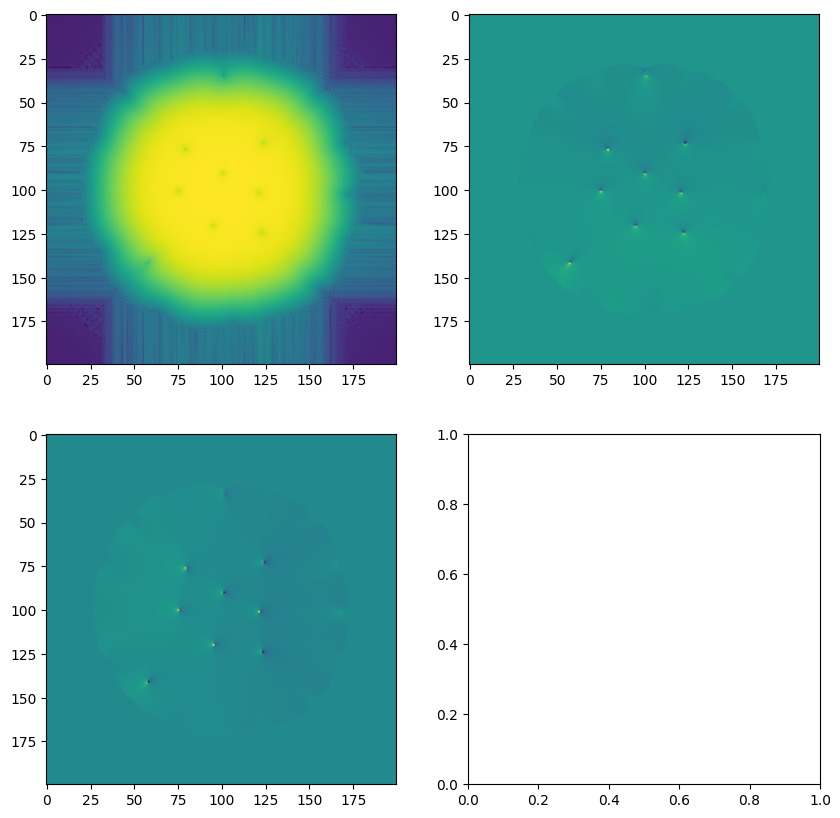

In [ ]:
# obtain one batch of training images
dataiter = iter(train_dl)
images, labels, masks = next(dataiter)
images = images.numpy()
labels = labels.numpy()
masks = masks.numpy()

# get one image from the batch
idx = 7
img = np.squeeze(images[idx])
lbl = np.squeeze(labels[idx])
msk = np.squeeze(masks[idx])

fig, axes = plt.subplots(2, 2, figsize = (10, 10))
axes[0, 0].imshow(img, cmap='viridis')
axes[0, 1].imshow(lbl[0], cmap='viridis')
axes[1, 0].imshow(lbl[1], cmap="viridis")


# Models

In [ ]:
def cutoff_to_angle(x):
    x = -F.relu(x + torch.pi) + 2*torch.pi
    x = F.relu(x) - torch.pi
    return x

## Convolutional and linear models

In [ ]:
class ConvToConv(nn.Module):
    """
    Convolution to deconvolution
    """
    def __init__(self, channel_depths, conv_k = 3, up_k = 2):
        super(ConvToConv, self).__init__()
        self.channel_depths = channel_depths
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.encoder = []
        for i in range(len(channel_depths)-1):
            cd1 = channel_depths[i]
            cd2 = channel_depths[i+1]
            self.encoder.append(nn.Conv2d(cd1, cd2, conv_k, padding = (conv_k - 1)//2))
            nn.BatchNorm2d(cd2, momentum = 0.2)
            self.encoder.append(nn.ReLU())
            self.encoder.append(nn.MaxPool2d(2, 2))
        self.encoder = nn.Sequential(*self.encoder)

        self.decoder = []
        for i in range(len(channel_depths)-1, 0, -1):
            cd1 = channel_depths[i]
            cd2 = channel_depths[i-1]
            self.decoder.append(nn.ConvTranspose2d(cd1, cd2, up_k, up_k))
            if i > 1: self.decoder.append(nn.ReLU())
        self.decoder = nn.Sequential(*self.decoder)
        self.translation_net = nn.Linear(625, 625)
        self.translation_nets = nn.ModuleList([nn.Linear(625, 625) for _ in range(16)])
        def apply_network(net, x):
            return net(x)  # Input shape: (625), Output shape: (625)

        self.apply_all_layers = torch.vmap(apply_network)

        # Second vmap: Applies across all batch elements
        self.apply_all_batches = torch.vmap(self.apply_all_layers, in_dims=(None, 0))

    def translate(self, x):

        # Apply to the entire batch
        x_flat = x.view(-1, 625)
        output_flat = self.translation_net(x_flat)

        # Reshape back to (batch_size, 16, 25, 25) if needed
        output = output_flat.view(-1, 16, 25, 25)

        return F.relu(output)

    def forward(self, x):
        x = self.encoder(x)
        x = self.translate(x)
        x = self.decoder(x)
        x = 2*torch.pi*(F.sigmoid(x)) - torch.pi

        return x

## Unet

In [ ]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels, momentum = 0.2),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels, momentum = 0.2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class FlattenedFC(nn.Module):
    def __init__(self, image_shape, in_channels, out_channels, hidden_layers = [1024, 1024], output_angle = False):
        """
        hidden_layers: List of integers defining hidden layer sizes
        image_shape: Single integer W, assuming (C, W, W)
        """
        super().__init__()
        self.image_shape = image_shape
        self.hidden_layers = hidden_layers
        self.output_angle = output_angle
        self.out_channels = out_channels
        layers = []
        flattened_shape_in = image_shape*image_shape*in_channels
        flattened_shape_out = image_shape*image_shape*out_channels
        prev_dim = flattened_shape_in
        for hidden_dim in self.hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.ReLU())
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, flattened_shape_out))
        self.fc = nn.Sequential(*layers)

    def forward(self, x):
        B, C, W1, W2 = x.shape
        assert W1 == self.image_shape and W2 == self.image_shape, f"Expected width {self.image_shape}, got ({W1}, {W2})"

        x = x.view(B, -1)  # Flatten
        x = self.fc(x)
        x = x.view(B, self.out_channels, self.image_shape, self.image_shape)  # Reshape back
        if self.output_angle:
            x = cutoff_to_angle(x)
        return x

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True, add_skip = True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        self.add_skip = add_skip
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        if self.add_skip:
            x = torch.cat([x2, x1], dim=1)
            #print(f"dim after concatenation: {x.shape}")
        else:
            x = x1
        #print(f"Running conv2d with {self.conv.double_conv[0].in_channels} in_channels, {self.conv.double_conv[-3].out_channels} out_channels")
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, channels, bilinear=True, add_skip = True, add_fc = False, bottleneck_dim = 1, verbose=False, out_channels = 1, wrap_angles = True):
        super(UNet, self).__init__()
        self.channels = channels
        self.bilinear = bilinear
        self.verbose = verbose
        self.add_fc = add_fc
        self.wrap_angles = wrap_angles

        self.inc = DoubleConv(channels[0], channels[1])
        if add_skip:
            #Repeat the final layer to add a skip connection in that layer
            self.downs = nn.ModuleList([Down(channels[i], channels[i+1]) for i in range(1, len(channels)-1)] +
                                       [Down(channels[-1], channels[-1])])
            self.ups = nn.ModuleList([Up(2*channels[i+1], channels[i], bilinear, add_skip) for i in range(len(channels)-2, 0, -1)] +
                                     [Up(2* channels[1], channels[1], bilinear, add_skip)])
        else:
            self.downs = nn.ModuleList([Down(channels[i], channels[i+1]) for i in range(1, len(channels)-1)])
            self.ups = nn.ModuleList([Up(channels[i+1], channels[i], bilinear, add_skip) for i in range(len(channels)-2, 0, -1)])
        self.outc = OutConv(channels[1], out_channels)

        if add_fc:
            self.fc = FlattenedFC(bottleneck_dim, channels[-1], channels[-1])

    def forward(self, x):
        x_stages = [self.inc(x)]
        if self.verbose:
            print(f"x1 shape: {x_stages[-1].shape}")

        for down in self.downs:
            x_stages.append(down(x_stages[-1]))
            if self.verbose:
                print(f"Down stage shape: {x_stages[-1].shape}")

        x = x_stages.pop()
        if self.add_fc:
            x = self.fc(x)
            if self.verbose:
                print(f"Fully connected output shape: {x.shape}")
        for up in self.ups:
            x = up(x, x_stages.pop())
            if self.verbose:
                print(f"Up stage shape: {x.shape}")

        x = self.outc(x)
        if self.verbose:
            print(f"Output shape: {x.shape}")

        #Make between -pi and pi
        if self.wrap_angles:
            x = -F.relu(x + torch.pi) + 2*torch.pi
            x = F.relu(x) - torch.pi
        return x
        #return 2*torch.pi*(F.sigmoid(x)) - torch.pi

In [ ]:
unet_4 = UNet(channels = [1, 4, 8, 16, 32, 64, 128, 256], add_skip = True, verbose = True, add_fc = False, out_channels = 2, wrap_angles = False)
dataiter = iter(train_dl)
images, labels, masks = next(dataiter)
output = unet_4(images);

x1 shape: torch.Size([8, 4, 200, 200])
Down stage shape: torch.Size([8, 8, 100, 100])
Down stage shape: torch.Size([8, 16, 50, 50])
Down stage shape: torch.Size([8, 32, 25, 25])
Down stage shape: torch.Size([8, 64, 12, 12])
Down stage shape: torch.Size([8, 128, 6, 6])
Down stage shape: torch.Size([8, 256, 3, 3])
Down stage shape: torch.Size([8, 256, 1, 1])
Up stage shape: torch.Size([8, 128, 3, 3])
Up stage shape: torch.Size([8, 64, 6, 6])
Up stage shape: torch.Size([8, 32, 12, 12])
Up stage shape: torch.Size([8, 16, 25, 25])
Up stage shape: torch.Size([8, 8, 50, 50])
Up stage shape: torch.Size([8, 4, 100, 100])
Up stage shape: torch.Size([8, 4, 200, 200])
Output shape: torch.Size([8, 2, 200, 200])


# Training


In [ ]:
def predict(dataloader, model, autoencoder = False):
    model.eval()
    inputs_list = []
    predictions = []
    ground_truths = []
    masks = []
    errors = []

    with torch.no_grad():
        for inputs, targets, mask_batch in dataloader:
            inputs, targets, mask_batch = inputs.to(device), targets.to(device), mask_batch.to(device)
            if autoencoder:
                targets = inputs
            preds = model(inputs).cpu().numpy()
            targets = targets.cpu().numpy()
            mask_batch = mask_batch.cpu().numpy()
            inputs_np = inputs.cpu().numpy()
            error = np.mean((preds - targets)**2 * (1-mask_batch), axis = (-1, -2, -3))
            inputs_list.extend(inputs_np)
            predictions.extend(preds)
            ground_truths.extend(targets)
            masks.extend(mask_batch)
            errors.extend(error)


    return np.array(inputs_list), np.array(predictions), np.array(ground_truths), np.array(errors), np.array(masks)

In [ ]:
def train_model(train_loader, model, criterion, optimizer, scheduler, epochs=10, device="cpu", autoencoder = False):
    model.to(device)
    model.train()
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, targets, masks in train_loader:
            inputs, targets, masks = inputs.to(device), targets.to(device), masks.to(device)
            if autoencoder:
                targets = inputs
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets, masks)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        _, predictions, ground_truths, val_errors, masks = predict(val_dl, model)
        val_loss = val_errors.mean()
        # median_loss = np.median(val_errors)
        # error_inds = np.argsort(val_errors)
        # ind_10 = error_inds[-len(error_inds)//10]
        # ind_med = error_inds[len(error_inds)//2]
        # checkpoint = {"10th percentile prediction": predictions[ind_10],
        #               "10th percentile gt": ground_truths[ind_10],
        #               "10th percentile mask": masks[ind_10],
        #               "10th percentile error": val_errors[ind_10],
        #               "Median prediction": predictions[ind_med],
        #               "Median gt": ground_truths[ind_med],
        #               "Median mask": masks[ind_med],
        #               "Median error": val_errors[ind_med],
        #               "Mean error": val_loss
        # }
        # val_checkpoints.append(checkpoint)
        print(f"Epoch {epoch+1} Train Loss: {total_loss / len(train_loader)}, Val Loss: {val_loss}")
        scheduler.step(val_loss, epoch)

In [ ]:
class CustomLRScheduler:
    def __init__(self, optimizer, patience=10, factor=0.5, min_lr=1e-6):
        self.optimizer = optimizer
        self.patience = patience  # Number of epochs to wait before reducing LR
        self.factor = factor  # LR decay factor
        self.min_lr = min_lr  # Minimum LR threshold
        self.best_loss = float('inf')
        self.total_loss = 0

    def step(self, val_loss, epoch):
        self.total_loss += val_loss
        if (epoch+1) % self.patience == 0:
            print(f"Accumulated loss: {self.total_loss}, best loss: {self.best_loss}")
            if self.total_loss >= self.best_loss:
                self._reduce_lr()
            else:
                self.best_loss = self.total_loss
                print("Average Validation loss (10 epochs) decreased!")
            self.total_loss = 0

    def _reduce_lr(self):
        for param_group in self.optimizer.param_groups:
            new_lr = param_group['lr'] * self.factor
            if new_lr < param_group['lr']:  # Only reduce if it's actually decreasing
                param_group['lr'] = new_lr
                print(f"Reducing learning rate to {new_lr:.6f}")


In [ ]:
images, labels, masks = next(dataiter)
# fully_connected = FlattenedFC(image_shape = 32, in_channels = 1, out_channels = 2, output_angle = True)
# encoder_decoder = UNet(channels = [1, 8, 16, 4], add_skip = False, add_fc = True, verbose = False, bottleneck_dim = 8, out_channels = 2)
unet_8 = UNet(channels = [1, 8, 16, 32, 64, 128, 256, 512], add_skip = True, verbose = False, add_fc = False, out_channels = 2, wrap_angles = False)
unet_4 = UNet(channels = [1, 4, 8, 16, 32, 64, 128, 256], add_skip = True, verbose = False, add_fc = False, out_channels = 2, wrap_angles = False)
unet_2 = UNet(channels = [1, 2, 4, 8, 16, 32, 64, 128], add_skip = True, verbose = False, add_fc = False, out_channels = 2, wrap_angles = False)

model_dict = {"unet_8":unet_8}

#Test models
for name, model in model_dict.items():
    model.to(device)
    model.eval()
    _, predictions, truths, errors, masks = predict(val_dl, model)
    print(f"{name}: {errors.mean()}")

unet_8: 0.07625064998865128


In [ ]:
p = 10
def mse_with_mask(outputs, targets, masks):
    return torch.mean(((outputs-targets)**2)*(1-masks))
for name, model in model_dict.items():
    val_checkpoints = []
    print(f"Training {name}")
    criterion = mse_with_mask
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = CustomLRScheduler(optimizer, patience=p, factor=0.5, min_lr=1e-6)
    train_model(train_dl, model, criterion, optimizer, scheduler, epochs=200, device=device, autoencoder = False)


Training unet_8
Epoch 1 Train Loss: 0.009579732352572064, Val Loss: 0.007929233834147453
Epoch 2 Train Loss: 0.0051509232873777075, Val Loss: 0.003937103785574436
Epoch 3 Train Loss: 0.004048356065703999, Val Loss: 0.003491218900308013
Epoch 4 Train Loss: 0.003410430268443648, Val Loss: 0.0030497717671096325
Epoch 5 Train Loss: 0.0031802443351360067, Val Loss: 0.0028917633462697268
Epoch 6 Train Loss: 0.0028905388335549523, Val Loss: 0.0029559277463704348
Epoch 7 Train Loss: 0.0028371670872845227, Val Loss: 0.0025332679506391287
Epoch 8 Train Loss: 0.002648487179872713, Val Loss: 0.0024345226120203733
Epoch 9 Train Loss: 0.0024884488500122514, Val Loss: 0.0023653425741940737
Epoch 10 Train Loss: 0.002308304145348273, Val Loss: 0.0022016512230038643
Accumulated loss: 0.033789802342653275, best loss: inf
Average Validation loss (10 epochs) decreased!
Epoch 11 Train Loss: 0.0021937013925274924, Val Loss: 0.0020572368521243334
Epoch 12 Train Loss: 0.00200043501616973, Val Loss: 0.001908133

KeyboardInterrupt: 

In [ ]:
inputs, predictions, truths, errors, masks = predict(val_dl, model)

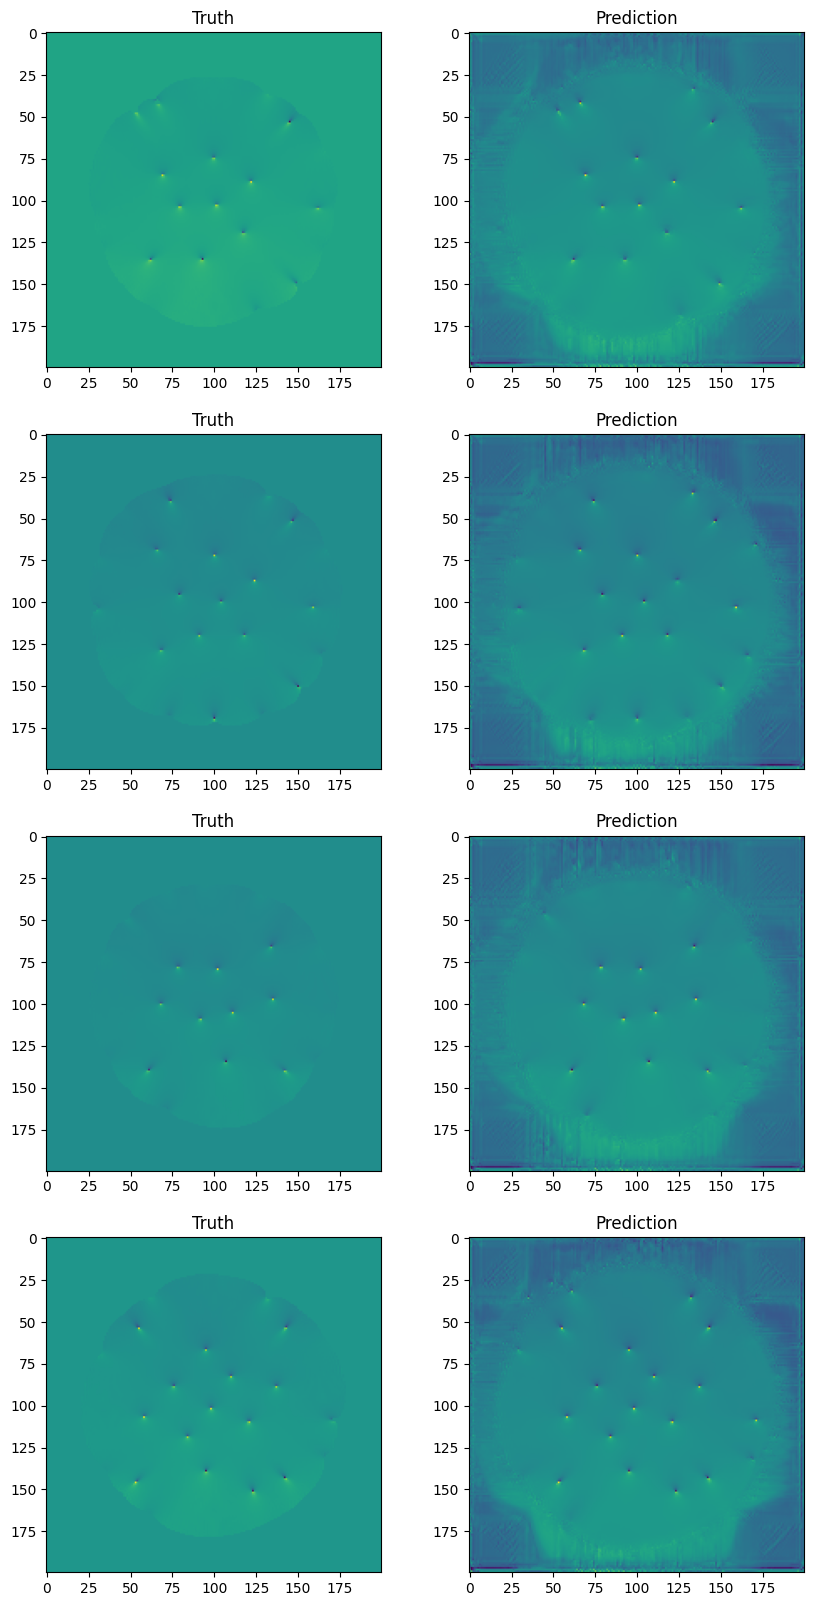

In [ ]:
n_plots = 4
fig, ax = plt.subplots(n_plots, 2, figsize = (10, 20))
for i in range(n_plots):
  ax[i, 0].imshow(truths[i][0], cmap = "viridis")
  ax[i, 1].imshow(predictions[i][0], cmap = "viridis")

  ax[i, 0].set_title("Truth")
  ax[i, 1].set_title("Prediction")


In [ ]:
errors = []
for checkpoint in val_checkpoints:
    errors.append(checkpoint["Mean error"])

Text(0, 0.5, 'Validation error')

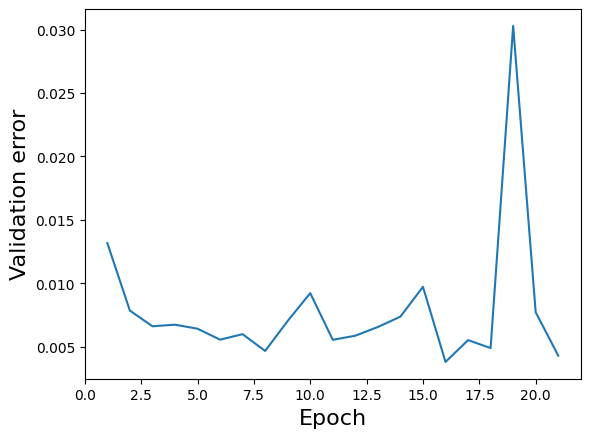

In [ ]:
plt.plot(np.arange(1, len(val_checkpoints) + 1), errors)
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Validation error", fontsize = 16)

# Evaluation

In [ ]:
# Load models
model_names = ["unet_8_gradients_log_density_e500"]
model_dict = {}
for name in model_names:
    # Instantiate the model architecture.
    # Assuming the saved model state dict corresponds to unet_8.
    model = UNet(channels = [1, 8, 16, 32, 64, 128, 256, 512], add_skip = True, verbose = False, add_fc = False, out_channels = 2, wrap_angles = False)
    # Load the state dictionary
    model.load_state_dict(torch.load(f"{model_loc}/{name}.pth"))
    model.to(device)
    model_dict[name] = model

In [ ]:
#Validation Inference
for name, model in model_dict.items():
    inputs, predictions, truths, errors, masks = predict(val_dl, model)
    np.savez(f"{data_loc}/{name}_val_predict", inputs = inputs, predictions = predictions, truths = truths, errors = errors, masks = masks)

In [ ]:
#test Inference
for name, model in model_dict.items():
    inputs, predictions, truths, errors, masks = predict(test_dl, model)
    np.savez(f"{data_loc}/{name}_test_predict", inputs = inputs, predictions = predictions, truths = truths, errors = errors, masks = masks)

In [ ]:
def visualize_predictions(inputs, predictions, ground_truths, errors, masks, percentiles=[0, 25, 50, 75, 100], save_name = None):
    sorted_indices = np.argsort(errors)[::-1]  # Sort in descending order
    percentiles_indices = [sorted_indices[int(p / 100 * (len(errors) - 1))] for p in percentiles]

    print(percentiles_indices)
    vmin = ground_truths.min()
    vmax = ground_truths.max()
    fig, axes = plt.subplots(len(percentiles), 3, figsize=(9, 3 * len(percentiles)))

    for i, idx in enumerate(percentiles_indices):
        ax_input, ax_pred, ax_gt = axes[i]
        ax_input.imshow(inputs[idx][0], cmap='viridis')
        ax_input.set_title(f'{percentiles[i]}th percentile Input')
        ax_input.axis('off')

        ax_pred.imshow(predictions[idx][0] * (1-masks[idx][0]), cmap='viridis', vmin = vmin, vmax = vmax)
        ax_pred.set_title(f'{percentiles[i]}th percentile prediction')
        ax_pred.axis('off')

        ax_gt.imshow(ground_truths[idx][0], cmap='viridis', vmin = vmin, vmax = vmax)
        ax_gt.set_title('Ground Truth')
        ax_gt.axis('off')

    plt.tight_layout()

    if save_name is not None:
        plt.savefig(save_name)
    plt.show()

In [ ]:
predictions_dict = {}
for name, model in model_dict.items():
    inputs, predictions, ground_truths, errors, masks = predict(test_dl, model, autoencoder = False)
    predictions_dict[name] = {"inputs": inputs,
                         "predictions": predictions,
                         "ground_truths": ground_truths,
                         "errors": errors,
                         "masks": masks}

test_phases = predictions_dict["unet_8_gradients_log_density_e500"]["ground_truths"]
test_masks = predictions_dict["unet_8_gradients_log_density_e500"]["masks"]
baseline_errors = np.mean((test_phases)**2 * (1-test_masks), axis = (-1, -2, -3))
baseline_errors.shape

(336,)

unet_8_gradients_log_density_e500


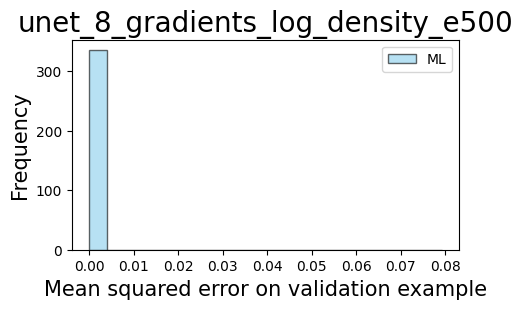

In [ ]:
fig, axes = plt.subplots(2, (len(model_dict)+1)//2, figsize=(5, 6*(len(model_dict)+1) // 2))

for (model_name, model), ax in zip(model_dict.items(), axes.flatten()):

    print(model_name)
    predictions = predictions_dict[model_name]
    all_errors = np.concatenate([predictions["errors"], baseline_errors])
    num_bins = 20  # Set number of bins or use 'auto'

    # Compute common bins
    bin_edges = np.histogram_bin_edges(all_errors, bins=num_bins)

    #ax.hist(baseline_errors, color='orange', edgecolor='black', label = "Baseline", alpha = 0.6, bins=bin_edges)
    ax.hist(predictions["errors"], color='skyblue', edgecolor='black', label = "ML", alpha = 0.6, bins=bin_edges)
    ax.set_title(f'{model_name}', fontsize = 20)
    ax.set_xlabel('Mean squared error on validation example', fontsize = 15)
    ax.set_ylabel('Frequency', fontsize = 15)
    ax.legend()

if len(model_dict) % 2 == 1:
    axes.flatten()[-1].set_visible(False)

plt.show()


unet_8_gradients_log_density_e500


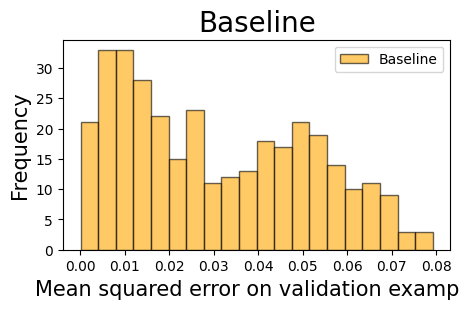

In [ ]:
fig, axes = plt.subplots(2, (len(model_dict)+1)//2, figsize=(5, 6*(len(model_dict)+1) // 2))

for (model_name, model), ax in zip(model_dict.items(), axes.flatten()):

    print(model_name)
    predictions = predictions_dict[model_name]
    all_errors = np.concatenate([predictions["errors"], baseline_errors])
    num_bins = 20  # Set number of bins or use 'auto'

    # Compute common bins
    bin_edges = np.histogram_bin_edges(all_errors, bins=num_bins)

    ax.hist(baseline_errors, color='orange', edgecolor='black', label = "Baseline", alpha = 0.6, bins=bin_edges)
    #ax.hist(predictions["errors"], color='skyblue', edgecolor='black', label = "ML", alpha = 0.6, bins=bin_edges)
    ax.set_title(f'Baseline', fontsize = 20)
    ax.set_xlabel('Mean squared error on validation example', fontsize = 15)
    ax.set_ylabel('Frequency', fontsize = 15)
    ax.legend()

if len(model_dict) % 2 == 1:
    axes.flatten()[-1].set_visible(False)

plt.show()


In [ ]:
val_phases.shape

(300, 2, 128, 128)

Text(0.5, 1.0, 'Ground truth')

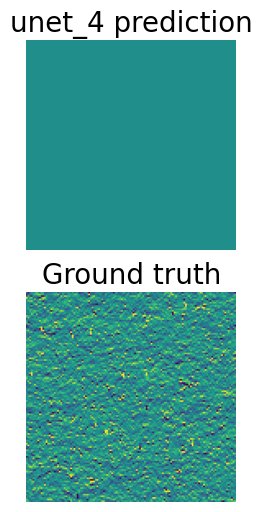

In [ ]:
fig, axes = plt.subplots(2, (len(model_dict))//2 + 1, figsize=(15, 6*(len(model_dict)+1) // 2))

with torch.no_grad():
    idx = 200
    xy = 1
    vmin = val_phases.min() / 2
    vmax = val_phases.max() / 2
    for model_name, ax in zip(model_dict.keys(), axes.flatten()):
        predictions = predictions_dict[model_name]["predictions"]
        masks = predictions_dict[model_name]["masks"]
        ax.imshow(predictions[idx][xy] * (1-masks[idx][0]), cmap='viridis', vmin=vmin, vmax=vmax)
        ax.axis('off')
        ax.set_title(f"{model_name} prediction", fontsize = 20)

axes[1].imshow(val_phases[idx][xy], cmap = 'viridis', vmin=vmin, vmax=vmax)
axes[1].axis('off')
axes[1].set_title(f"Ground truth", fontsize = 20)


In [ ]:
#Save models
for name, model in model_dict.items():
    torch.save(model.state_dict(), f"drive/MyDrive/Columbia Research/Bose Einstein Condensation ML/models/{name}_gradients_log_density_e500.pth")

In [ ]:
#Save validation predictions
for name, model in model_dict.items():
    inputs, predictions, truths, errors, masks = predict(val_dl, model)
    np.savez(f"{data_loc}/{name}_gradients_log_density", inputs = inputs, predictions = predictions, truths = truths, errors = errors, masks = masks)